  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  
            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               

AttributeError: 'numpy.bool_' object has no attribute 'startswith'

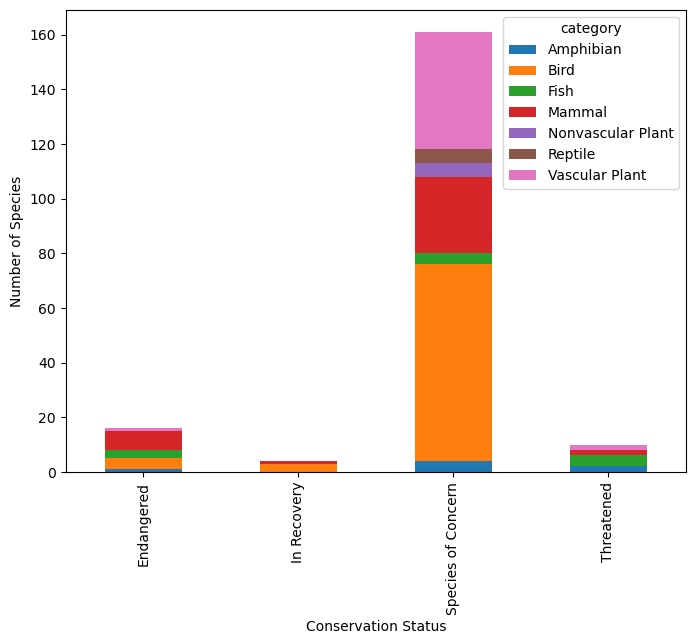

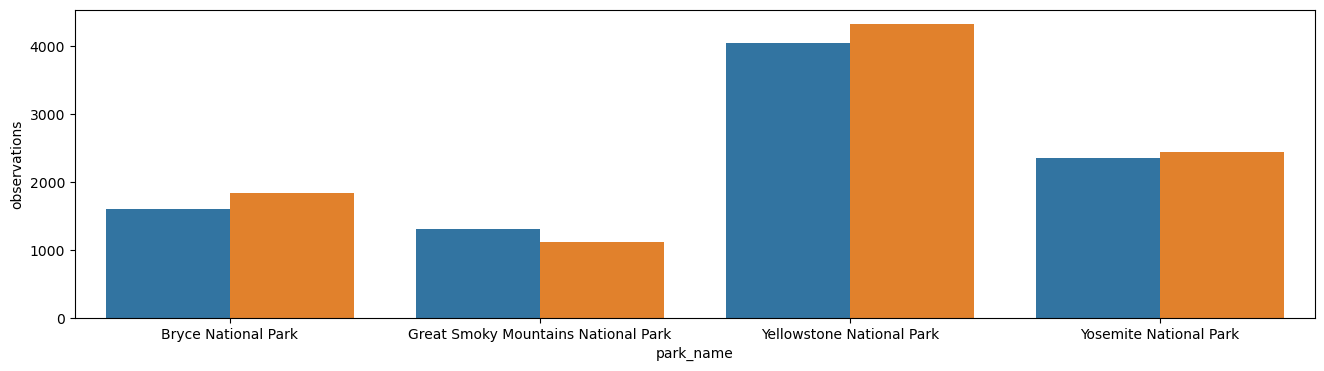

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from itertools import chain
import string

%matplotlib inline

#load datasets and display initial data
species = pd.read_csv('species_info.csv', encoding = 'utf-8')
print(species.head())

observations = pd.read_csv('observations.csv', encoding = 'utf-8')
print(observations.head())

#basic info about datasets
print(f'species shape: {species.shape}')
print(f'observations shape: {observations.shape}')

print(f'number of species: {species.category.nunique()}')
print(f'categories: {species.category.unique()}')

species.groupby('category').size()

print(f'number of conservation statuses: {species.conservation_status.nunique()}')
print(f'unique conservation statuses: {species.conservation_status.unique()}')

print(f'na values: {species.conservation_status.isna().sum()}')
print(species.groupby('conservation_status').size())

print(f'number of parks: {observations.park_name.nunique()}')
print(f'unique parks: {observations.park_name.unique()}')

print(f'number of observations: {observations.observations.sum()}')

species.fillna('None', inplace = True)
species.groupby('conservation_status').size()

consCat = species[species.conservation_status != 'None'].groupby(['conservation_status', 'category'])['scientific_name'].count().unstack()

print(consCat)

ax = consCat.plot(kind = 'bar', figsize = (8, 6), stacked = True)
ax.set_xlabel('Conservation Status')
ax.set_ylabel('Number of Species')

species['is_protected'] = species.conservation_status != 'None'

category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns = 'is_protected', index = 'category', values = 'scientific_name').reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']
print(category_counts)

category_counts['percent_protected'] = category_counts.protected / (category_counts.protected + category_counts.not_protected) * 100

print(category_counts)

contingency1 = [[30, 146], [75, 413]]
print(chi2_contingency(contingency1))


contingency2 = [[30, 146], [5, 73]]
print(chi2_contingency(contingency2))

def del_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
common_names = species[species.category == 'Mammal'].common_names.apply(del_punctuation).str.split().tolist()
print(common_names[:6])

clean_rows = []
for item in common_names:
    item = list(dict.fromkeys(item))
    clean_rows.append(item)

print(clean_rows[:6])

res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in clean_rows))
print(res[:6])

words_counted = []
for i in res:
    x = res.count(i)
    words_counted.append((i, x))

pd.DataFrame(set(words_counted), columns = ['Word', 'Count']).sort_values('Count', ascending = False).head()

species['is_bat'] = species.common_names.str.contains(r'\bBat\b', regex = True)
print(species.head())
print(species[species.is_bat])

bat_observations = observations.merge(species[species.is_bat])
print(bat_observations)

bat_observations.groupby('park_name').observations.sum().reset_index()

obs_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
print(obs_park)

plt.figure(figsize = (16, 4))
sns.barplot(x = obs_park['park_name'], y = obs_park['observations'], hue = obs_park['is_protected'])
plt.xlabel('National parks')
plt.ylabel('Number of observations')
plt.title('Number of bat observations per week')
plt.show()